___
## Attempt to convert osm to geojson failed - how to download maps dynamically?

In [1]:
# min_long = 37.52408
# min_lat = 55.70015
# max_long = 37.54093
# max_lat = 55.70514
# addr = "\"https://api.openstreetmap.org/api/0.6/map?bbox=" \
#     + str(min_long)  + ',' + str(min_lat) + ',' + str(max_long) + ',' + str(max_lat) + '"'

# !curl -o test_map.osm $addr

# import shutil
# import sys
# !mv test_map.osm data
# # with open('data/test_map.osm', encoding='utf-8') as file:
# #     shutil.copyfileobj(file, sys.stdout)

In [2]:
# import codecs
# import osm2geojson
# import geopandas

# with codecs.open('data/test_map.osm', 'r', encoding='utf-8') as data:
#     xml = data.read()

# geojson = osm2geojson.xml2geojson(xml, filter_used_refs=False, log_level='INFO')

# gp.read_file(geojson)

[Parts of the world](http://download.geofabrik.de/)  
[Cities](https://download.bbbike.org/osm/bbbike/)  
[Choose borders](https://extract.bbbike.org/)  
[OSM API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) - possible solution

___
## Using predownloaded map

In [1]:
from parsers.osm_parser import OsmParser

filename = "maps/kozlovo.osm.pbf"
bbox = [35.9, 56.575, 36.12, 56.6]
map_data = OsmParser(filename, bbox)

/home/denis/.local/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


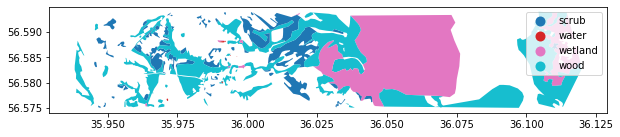

In [3]:
map_data.polygons.plot(column='natural', legend=True, figsize=(10,6));

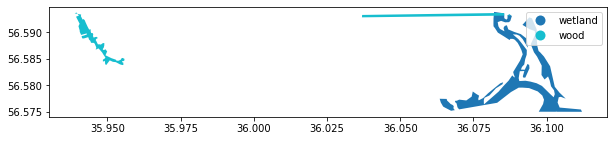

In [4]:
if not map_data.multipolygons.empty:
    map_data.multipolygons.plot(column='natural', legend=True, figsize=(10,6));

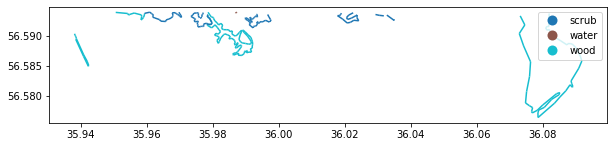

In [5]:
if not map_data.multilinestrings.empty:
    map_data.multilinestrings.plot(column='natural', legend=True, figsize=(10,6));

In [2]:
epsilon = 0.001
bbox_comp = 25
polygons, multilinestrings = map_data.build_dataframe(epsilon, bbox_comp)

___
## Build a graph

In [3]:
from graph import build_graph
import matplotlib.pyplot as plt
import mplleaflet

In [ ]:
%%time
view_angle = 5
G, fig = build_graph(polygons, multilinestrings, plot=False, view_angle=view_angle, use_centroid=False)
# mplleaflet.display(fig=fig)

In [6]:
print(G.number_of_edges())
print(G.number_of_nodes())

1094
127


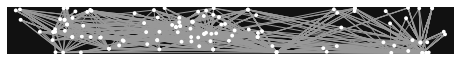

In [41]:
import osmnx as ox
ox.plot_graph(G);

In [3]:
def add_point(new_point, point, view_angle_std, crosses, node):
    x = new_point[0]
    y = new_point[1]
    x_rel = x - point[0]
    y_rel = y - point[1]
    dist = graph.mod((x_rel, y_rel))
    k1 = math.ceil(math.atan2(y_rel, x_rel) * 180 / math.pi / view_angle_std)
    if crosses[k1] is None or crosses[k1][0] > dist:
        crosses[k1] = [dist, [x, y, node]]
    return x, y, x_rel, y_rel, k1

In [4]:
def add_points(point1, point2, point, view_angle_std, crosses, node1, node2):
    x1, y1, x1_rel, y1_rel, k1 = add_point(point1, point, view_angle_std, crosses, node1)
    x2, y2, x2_rel, y2_rel, k2 = add_point(point2, point, view_angle_std, crosses, node2)
    for p in range(min(k1, k2) + 1, max(k1, k2)):
        k_curr = math.tan((p * view_angle_std + 0.00001)*math.pi/180)
        if x1_rel == x2_rel:
            k_segment = 100000
        else:
            k_segment = (y1_rel - y2_rel) / (x1_rel - x2_rel)
        b_segment = y1_rel - k_segment * x1_rel
        x = b_segment / (k_curr - k_segment)
        y = k_curr * x
        if not graph.point_in_angle((x, y), (x1_rel, y1_rel), (0, 0), (x2_rel, y2_rel)):
            continue
        dist = graph.mod((x, y))
        if crosses[p] is None or crosses[p][0] > dist:
            crosses[p] = [dist, None]

In [13]:
import graph
import networkx as nx
import math

In [17]:
def build_graph(polygons, plot=False, view_angle=None, use_centroid=False):
    fig = plt.figure()
    G = nx.MultiGraph(crs='EPSG:4326')
    max_poly_len = 10000 # for graph indexing
    polygon_number = polygons.shape[0]
    multilinestring_number = multilinestrings.shape[0]
    for i in range(polygon_number):
        coords_1 = polygons.coords[i]
        if coords_1 is None:
            continue
        n = len(coords_1) - 1
        for k in range(n):
            point = coords_1[k]
            left_border = coords_1[(k-1)%n]
            right_border = coords_1[(k+1)%n]
            G.add_node(i * max_poly_len + k, x=point[0], y=point[1])     
            view_angle_std = 1 if view_angle is None or view_angle == 0 else view_angle
            angle_count = math.floor(360 / view_angle_std)
            crosses = [None for p in range(angle_count)]
            for j in range(multilinestring_number):
                line_coords = multilinestrings.coords[j]
                if line_coords is None:
                    continue
                m = len(line_coords) - 1
                stay = False
                for k in range(m):
                    if not stay:
                        point1 = line_coords[k]
                        point1_index = k
                    point2 = line_coords[k + 1]
#                     if (min(bbox_width, bbox_length) / graph.mod(graph.vec(point1, point2)) > bbox_comp):
#                         stay = True
#                         continue
                    if view_angle is not None:
                        delta_angle = view_angle * math.pi / 180
                        if graph.angle(point1, point, point2) < delta_angle:
                            stay = True
                            continue
                    node1 = (j + 0.33) * max_poly_len + point1_index
                    node2 = (j + 0.33) * max_poly_len + k + 1
                    G.add_node(node1, x=point1[0], y=point1[1])
                    G.add_node(node2, x=point2[0], y=point2[1])
                    G.add_edge(node1, node2)
                    add_points(point1, point2, point, view_angle_std, crosses, node1, node2)
            for j in range(polygon_number):
                if j == i: # adding nodes inside a polygon
                    for t in range (n):
                        if t == k:
                            continue
                        other_point = coords_1[t]
                        G.add_node(i * max_poly_len + t, x=other_point[0], y=other_point[1])
                        G.add_edge(i * max_poly_len + t, i * max_poly_len + k)
                        if plot:
                            plt.plot([point[0], other_point[0]], [point[1], other_point[1]])
                    continue 
                coords_2 = polygons.coords[j]
                if coords_2 is None:
                    continue
                pair = graph.Graph.find_pair_array(point, left_border, right_border, coords_2)
                if pair is None:
                    continue
                left, right = pair
                left_coords = coords_2[left]
                right_coords = coords_2[right]
                if view_angle is not None:
                    delta_angle = view_angle * math.pi / 180
                    if graph.angle(left_coords, point, right_coords) < delta_angle:
                        if use_centroid:
                            node = (j + 0.66) * max_poly_len
                            G.add_node(node, x=point2[0], y=point2[1])
                            G.add_edge(node, i * max_poly_len + k)
                            add_point(polygons.centroid[j], point, view_angle_std, crosses, node)
                        continue
                add_points(left_coords, right_coords, point, view_angle_std, crosses,
                           j * max_poly_len + left, j * max_poly_len + right)
            for p in range(angle_count):
                if crosses[p] is not None and crosses[p][1] is not None:
                    G.add_node(crosses[p][1][2], x = crosses[p][1][0], y = crosses[p][1][1])
                    G.add_edge(crosses[p][1][2], i * max_poly_len + k)
                    if plot:
                        plt.plot([point[0], crosses[p][1][0]], [point[1], crosses[p][1][1]]);
    return G, fig

In [7]:
import matplotlib.pyplot as plt
import mplleaflet

___
Problems:
- Calculated angles and distances do not concern lan and lot difference
- Unoptimized linestring to bbox compare (should be while building dataframe)
- Possibly slow convex hull
- Additional natural attributes not in dataframe
- How to store graph?